## Initialization

In [26]:
import pandas as pd

In [27]:
years = list(range(1999, 2024))

In [28]:
csv_files = [f"./Data/play_by_play_{year}.csv" for year in years]

In [29]:
# load each csv file as a dataframe and collect them in a list
dataframes = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dataframes.append(df)

C:\Users\Tim\AppData\Local\Temp\ipykernel_9804\2200896479.py:4: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\Tim\AppData\Local\Temp\ipykernel_9804\2200896479.py:4: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\Tim\AppData\Local\Temp\ipykernel_9804\2200896479.py:4: DtypeWarning: Columns (37,179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\Tim\AppData\Local\Temp\

## Removal of Useless Observations
Thilo & Tok

In [30]:
list(dataframes[0]["play_type"].unique())

['kickoff',
 'pass',
 'run',
 'no_play',
 'punt',
 'extra_point',
 nan,
 'field_goal',
 'qb_kneel',
 'qb_spike']

In [79]:
# remove useless plays from dataframes to reduce size for combining dataframes
for dataframe in dataframes:
    dataframe.drop(
        dataframe[~dataframe["play_type"].isin(["pass", "run"])].index,
        axis=0,
        inplace=True,
    )

In [80]:
# combine all dataframes into a single one
combined_df = pd.concat(dataframes, axis=0)

# reset the index of the combined dataframe
combined_df.reset_index(drop=True, inplace=True)

In [81]:
# with penalty = 1 higher avg yards_gained -> biased (free plays etc)

display(combined_df[combined_df['penalty'] == 1].describe())
display(combined_df[combined_df['penalty'] == 0].describe())

,play_id,old_game_id,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
count,6325.000000,6.325000e+03,6325.000000,6325.000000,6325.000000,6325.000000,6325.000000,6325.0,6315.000000,6325.000000,...,6325.00000,6325.000000,6324.000000,3844.000000,3845.000000,3845.000000,3844.000000,3845.000000,5013.000000,5013.000000
mean,2194.859763,2.012118e+09,9.196206,51.910356,408.810119,782.185613,1619.150040,0.0,12.681552,0.071462,...,0.14419,0.481107,0.349462,0.748358,5.736086,3.895709,0.761383,0.575227,0.721621,27.837903
std,1146.809761,6.368827e+06,5.303525,23.375568,266.816866,528.954114,984.100356,0.0,6.724058,0.257616,...,0.35131,0.499682,2.501088,0.503435,2.611753,2.623593,0.261456,0.361138,0.216636,21.663554
min,51.000000,2.001091e+09,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,0.00000,0.000000,-12.004683,0.007620,0.472008,0.000000,0.042334,0.015083,0.088078,0.242025
25%,1261.000000,2.006123e+09,4.000000,34.000000,165.000000,296.000000,776.000000,0.0,7.000000,0.000000,...,0.00000,0.000000,-1.426036,0.327952,3.835772,2.000000,0.540612,0.237832,0.517129,6.044894
50%,2227.000000,2.012113e+09,9.000000,55.000000,391.000000,751.000000,1639.000000,0.0,13.000000,0.000000,...,0.00000,0.000000,1.040271,0.643031,4.823173,3.000000,0.973276,0.472677,0.751421,24.857903
75%,3139.000000,2.017122e+09,14.000000,72.000000,635.000000,1228.000000,2380.000000,0.0,18.000000,0.000000,...,0.00000,1.000000,2.052287,1.059105,7.402649,6.000000,1.000000,0.999369,0.939551,48.287147
max,5417.000000,2.023111e+09,22.000000,99.000000,900.000000,1800.000000,3600.000000,0.0,36.000000,1.000000,...,1.00000,1.000000,8.217517,5.539811,20.378528,19.000000,1.000000,1.000000,0.997580,91.192187


,play_id,old_game_id,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
count,467036.000000,4.670360e+05,467036.000000,467036.000000,467035.000000,467035.000000,467035.000000,467036.0,466308.000000,467036.000000,...,467036.000000,467036.000000,467035.000000,288981.000000,289028.000000,289028.000000,289028.000000,289028.000000,338179.000000,338179.000000
mean,2098.702072,2.011193e+09,9.435669,52.296690,422.044645,812.555635,1702.351903,0.0,12.229758,0.044954,...,0.106833,0.490891,0.023788,0.692751,5.281754,3.447604,0.795564,0.596574,0.710358,28.964157
std,1200.319206,7.092048e+06,5.311739,23.641731,274.296672,547.709801,1039.832847,0.0,7.018517,0.207203,...,0.308902,0.499918,1.563279,0.508918,2.415121,2.409927,0.247647,0.356393,0.218871,21.887056
min,20.000000,1.999091e+09,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,-13.031218,-1.282040,0.210289,0.000000,0.010270,0.000000,0.020049,0.181276
25%,1077.000000,2.005103e+09,5.000000,35.000000,167.000000,302.000000,798.000000,0.0,6.000000,0.000000,...,0.000000,0.000000,-0.747181,0.309432,3.656239,2.000000,0.582691,0.244902,0.503432,6.836548
50%,2086.000000,2.011120e+09,9.000000,56.000000,408.000000,792.000000,1794.000000,0.0,12.000000,0.000000,...,0.000000,0.000000,-0.232974,0.571406,4.507349,3.000000,0.987613,0.510156,0.731744,26.825625
75%,3101.000000,2.017113e+09,14.000000,72.000000,661.000000,1284.000000,2562.000000,0.0,18.000000,0.000000,...,0.000000,1.000000,0.904136,0.928549,6.417842,5.000000,1.000000,0.999181,0.931635,49.656835
max,5899.000000,2.023111e+09,22.000000,99.000000,900.000000,1800.000000,3600.000000,0.0,38.000000,1.000000,...,1.000000,1.000000,9.129719,13.028143,34.043324,48.000000,1.000000,1.000000,0.998187,97.995057


In [82]:
# drop plays with penalties
combined_df.drop(combined_df[combined_df["penalty"] == 1].index, axis=0, inplace=True)

In [83]:
# drop two point conversion plays
combined_df.drop(
    combined_df[~combined_df["two_point_conv_result"].isna()].index, axis=0, inplace=True
)

,play_id,old_game_id,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
count,228.000000,2.280000e+02,228.000000,228.000000,228.000000,228.000000,228.000000,228.0,228.000000,228.000000,...,228.000000,228.000000,228.000000,163.000000,163.000000,163.000000,163.000000,163.000000,168.000000,168.000000
mean,3543.951754,2.011680e+09,9.390351,66.245614,95.144737,158.302632,497.776316,0.0,20.228070,0.048246,...,0.214912,0.574561,0.291306,0.384662,5.274676,3.374233,0.791432,0.534365,0.901857,9.814276
std,1103.070689,7.223624e+06,5.047029,18.678623,202.278652,360.994943,890.812448,0.0,6.931426,0.214756,...,0.411665,0.495497,1.275671,0.534754,2.314040,2.666865,0.284042,0.357368,0.160804,16.080427
min,149.000000,1.999100e+09,1.000000,4.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,...,0.000000,0.000000,-2.009599,-1.282040,2.822006,0.000000,0.017248,0.017248,0.193466,0.237936
25%,3267.500000,2.005113e+09,5.000000,58.000000,4.000000,4.000000,5.000000,0.0,17.750000,0.000000,...,0.000000,0.000000,-0.072719,0.068531,3.580416,1.000000,0.560816,0.235674,0.909609,1.116320
50%,3986.500000,2.012102e+09,9.000000,70.000000,9.000000,9.000000,10.500000,0.0,22.000000,0.000000,...,0.000000,1.000000,0.012209,0.159794,4.332223,2.000000,0.996231,0.383546,0.973584,2.641600
75%,4222.500000,2.018102e+09,14.000000,80.000000,45.750000,48.250000,485.500000,0.0,25.000000,0.000000,...,0.000000,1.000000,0.286239,0.523876,6.830261,5.000000,1.000000,0.993848,0.988837,9.039125
max,5129.000000,2.023111e+09,21.000000,99.000000,900.000000,1708.000000,3508.000000,0.0,32.000000,1.000000,...,1.000000,1.000000,6.998616,2.803931,12.302560,12.000000,1.000000,1.000000,0.997621,80.653375


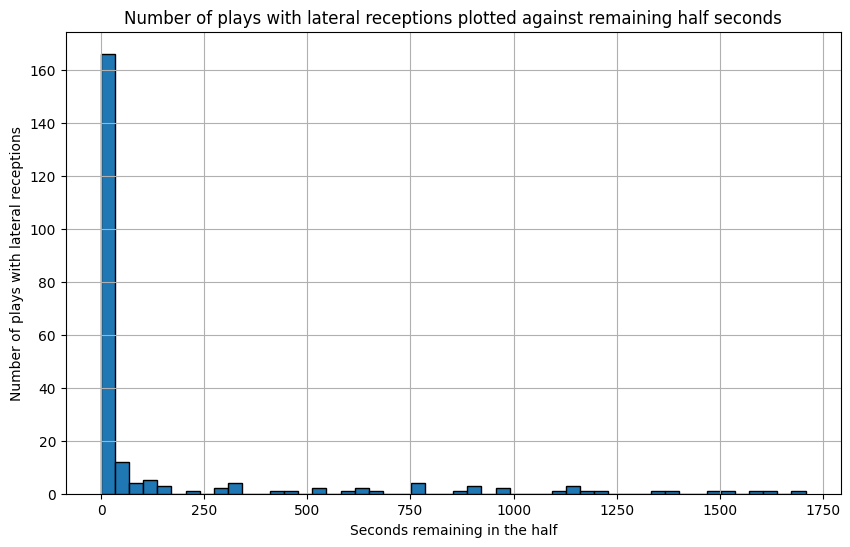

In [84]:
import matplotlib.pyplot as plt

# 75 perc. quant. is at 48 sec / half -> only end of half -> biased

display(combined_df[combined_df['lateral_reception'] == 1].describe())

lateral_reception_entries = combined_df[combined_df['lateral_reception'] == 1]

# grouped by 'half_seconds_remaining' and count number of occurrences
grouped_data = lateral_reception_entries.groupby('half_seconds_remaining').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.hist(lateral_reception_entries['half_seconds_remaining'], bins=50, edgecolor='black')
plt.title('Number of plays with lateral receptions plotted against remaining half seconds')
plt.xlabel('Seconds remaining in the half')
plt.ylabel('Number of plays with lateral receptions')
plt.grid(True)
plt.show()

In [85]:
# drop plays with laterals
combined_df.drop(
    combined_df[combined_df["lateral_reception"] == 1].index, axis=0, inplace=True
)

,play_id,old_game_id,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


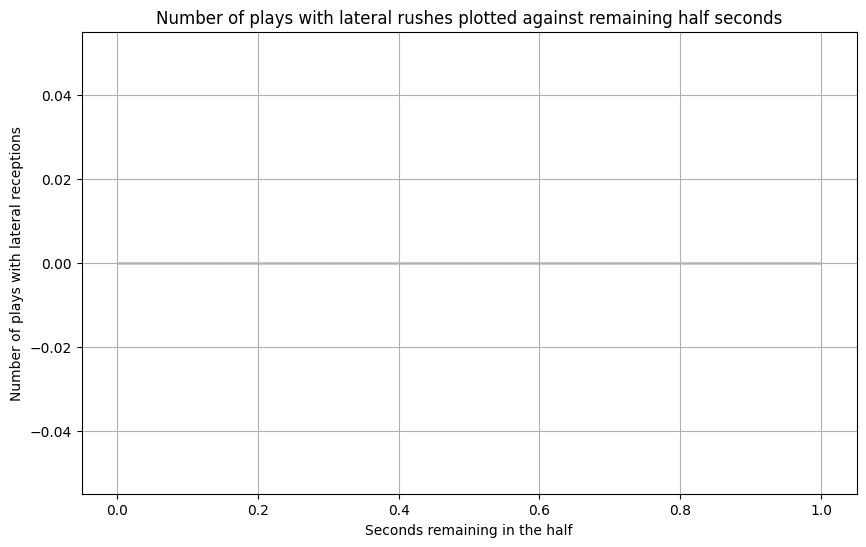

In [86]:
# don't drop -> lateral rushs also end around or trick plays -> same reasoning as above, but other way around

display(combined_df[combined_df['lateral_rush'] == 1].describe())

lateral_rush_entries = combined_df[combined_df['lateral_rush'] == 1]

# grouped by 'half_seconds_remaining' and count number of occurrences
grouped_data = lateral_rush_entries.groupby('half_seconds_remaining').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.hist(lateral_rush_entries['half_seconds_remaining'], bins=20, edgecolor='black')
plt.title('Number of plays with lateral rushes plotted against remaining half seconds')
plt.xlabel('Seconds remaining in the half')
plt.ylabel('Number of plays with lateral receptions')
plt.grid(True)
plt.show()

In [87]:
# don't drop -> doesn't change anything if replayed or not

display(combined_df[combined_df['replay_or_challenge'] == 1].describe())

,play_id,old_game_id,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
count,6064.000000,6.064000e+03,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.0,6055.000000,6064.000000,...,6064.000000,6064.000000,6064.000000,3699.000000,3701.000000,3701.000000,3701.000000,3701.000000,4700.000000,4700.000000
mean,2294.796174,2.011722e+09,9.552441,45.858509,367.923153,680.043865,1536.112467,0.0,13.165813,0.141985,...,0.185191,0.489446,0.014539,0.781994,4.699556,2.878681,0.860569,0.741843,0.755398,24.460153
std,1186.419845,6.654359e+06,5.345977,25.597903,277.325623,539.495205,1004.176186,0.0,6.905630,0.349064,...,0.388485,0.499930,2.432445,0.820116,2.521296,2.074460,0.223948,0.323306,0.220473,22.047306
min,51.000000,1.999091e+09,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,-12.270567,-0.521982,0.276749,0.000000,0.026688,0.021646,0.087907,0.360012
25%,1365.750000,2.006113e+09,5.000000,24.000000,112.000000,144.000000,623.750000,0.0,8.000000,0.000000,...,0.000000,0.000000,-0.966976,0.300886,3.245168,2.000000,0.703949,0.431690,0.562337,4.456681
50%,2215.000000,2.012112e+09,10.000000,48.000000,319.500000,607.000000,1666.000000,0.0,13.000000,0.000000,...,0.000000,0.000000,-0.209429,0.562153,4.099234,2.000000,0.998955,0.994828,0.835563,16.443717
75%,3298.500000,2.017112e+09,14.000000,68.000000,605.000000,1118.250000,2264.250000,0.0,19.000000,0.000000,...,0.000000,1.000000,1.608068,0.972308,5.551922,4.000000,1.000000,1.000000,0.955433,43.766309
max,5401.000000,2.023111e+09,22.000000,99.000000,900.000000,1800.000000,3600.000000,0.0,38.000000,1.000000,...,1.000000,1.000000,7.904483,11.146741,18.862334,18.000000,1.000000,1.000000,0.996400,91.209327


In [88]:
# plays where the snap is mishandled or dropped etc
display(combined_df[combined_df['aborted_play'] == 1].describe())

,play_id,old_game_id,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
count,234.000000,2.340000e+02,234.000000,234.000000,234.000000,234.000000,234.000000,234.0,234.000000,234.000000,...,234.000000,234.000000,234.000000,120.000000,120.000000,120.000000,120.000000,120.000000,184.000000,184.000000
mean,2177.666667,2.011610e+09,9.089744,51.068376,393.918803,736.226496,1651.611111,0.0,12.628205,0.029915,...,0.047009,0.504274,-0.568886,0.764139,6.085294,4.350000,0.728115,0.572227,0.764301,23.569945
std,1267.083458,6.010620e+06,5.176339,24.464295,278.355729,545.268556,1090.639517,0.0,7.216652,0.170717,...,0.212111,0.501054,1.486115,0.553818,3.091304,3.208838,0.295245,0.371091,0.211852,21.185207
min,87.000000,1.999091e+09,1.000000,1.000000,2.000000,2.000000,3.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,-8.808314,0.136530,0.539623,0.000000,0.061383,0.032534,0.172530,0.588697
25%,1108.000000,2.007031e+09,4.000000,33.250000,144.500000,200.750000,679.750000,0.0,6.250000,0.000000,...,0.000000,0.000000,-1.336548,0.319769,3.818067,2.000000,0.493213,0.233105,0.587628,5.004932
50%,2101.500000,2.013111e+09,9.000000,52.000000,350.000000,687.500000,1805.500000,0.0,12.000000,0.000000,...,0.000000,1.000000,-0.624715,0.593810,4.851438,3.000000,0.905781,0.503903,0.856591,14.340869
75%,3274.500000,2.017098e+09,13.000000,71.750000,632.500000,1188.500000,2602.000000,0.0,19.000000,0.000000,...,0.000000,1.000000,-0.149420,1.095944,8.347498,7.000000,1.000000,0.998139,0.949951,41.237207
max,4777.000000,2.023092e+09,21.000000,95.000000,900.000000,1796.000000,3567.000000,0.0,29.000000,1.000000,...,1.000000,1.000000,6.864812,2.828045,14.400057,12.000000,1.000000,1.000000,0.994113,82.746983


In [89]:
# drop aborted plays
combined_df.drop(
    combined_df[combined_df["aborted_play"] == 1].index, axis=0, inplace=True
)

In [90]:
print(len(list(combined_df["passer_id"].unique())))

passer_counts = combined_df['passer_id'].value_counts()

plays_per_passer_per_season = combined_df.groupby(['passer_id', 'season']).size().reset_index(name='play_count')
average_plays_per_season = plays_per_passer_per_season.groupby('season')['play_count'].mean().mean()
print(average_plays_per_season)

passers_with_min_entries = passer_counts[passer_counts >= average_plays_per_season].index
combined_df = combined_df[combined_df['passer_id'].isin(passers_with_min_entries)]

print(len(list(combined_df["passer_id"].unique())))

display(combined_df.shape)

791
181.18422895384785
239


(455887, 372)

In [112]:
len(list(combined_df["start_time"].unique()))

175

## Handling of Missing Values
Tok

In [91]:
display(combined_df[(combined_df['roof'].isna())].groupby('game_id').count())

,play_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
game_id,,,,,,,,,,,,,,,,,,,,,
2021_01_JAX_HOU,85,85,85,85,85,85,85,85,85,85,...,85,85,85,76,76,76,76,76,85,85
2021_01_PHI_ATL,69,69,69,69,69,69,69,69,69,69,...,69,69,69,61,61,61,61,61,69,69
2021_01_SEA_IND,66,66,66,66,66,66,66,66,66,66,...,66,66,66,51,51,51,51,51,66,66
2021_02_LA_IND,65,65,65,65,65,65,65,65,65,65,...,65,65,65,53,53,53,53,53,65,65
2021_03_CAR_HOU,68,68,68,68,68,68,68,68,68,68,...,68,68,68,56,56,56,56,56,68,68
2021_04_WAS_ATL,76,76,76,76,76,76,76,76,76,76,...,76,76,76,66,66,66,66,66,76,76
2021_05_NE_HOU,60,60,60,60,60,60,60,60,60,60,...,60,60,60,51,51,51,51,51,60,60
2021_06_HOU_IND,66,66,66,66,66,66,66,66,66,66,...,66,66,66,57,57,57,57,57,66,66
2021_08_CAR_ATL,54,54,54,54,54,54,54,54,54,54,...,54,54,54,47,47,47,47,47,54,54


In [92]:
"""
https://www.nfl.com/games/jaguars-at-texans-2021-reg-1 (closed)
https://www.nfl.com/games/eagles-at-falcons-2021-reg-1 (open)
https://www.nfl.com/games/seahawks-at-colts-2021-reg-1 (closed)
https://www.nfl.com/games/rams-at-colts-2021-reg-2 (closed)
https://www.nfl.com/games/panthers-at-texans-2021-reg-3 (closed)
https://www.nfl.com/games/football-team-at-falcons-2021-reg-4 (open)
https://www.nfl.com/games/patriots-at-texans-2021-reg-5  (closed)
https://www.nfl.com/games/texans-at-colts-2021-reg-6 (open)
https://www.nfl.com/games/panthers-at-falcons-2021-reg-8 (open)
https://www.nfl.com/games/rams-at-texans-2021-reg-8 (closed)
https://www.nfl.com/games/titans-at-colts-2021-reg-8 (open)
https://www.nfl.com/games/jets-at-colts-2021-reg-9 (closed)
https://www.nfl.com/games/jaguars-at-colts-2021-reg-10 (closed)
https://www.nfl.com/games/patriots-at-falcons-2021-reg-11 (closed)
https://www.nfl.com/games/jets-at-texans-2021-reg-12 (closed)
https://www.nfl.com/games/buccaneers-at-colts-2021-reg-12 (closed)
https://www.nfl.com/games/colts-at-texans-2021-reg-13 (closed)
https://www.nfl.com/games/buccaneers-at-falcons-2021-reg-13 (closed)
https://www.nfl.com/games/seahawks-at-texans-2021-reg-14 (open)
https://www.nfl.com/games/patriots-at-colts-2021-reg-15 (closed)
https://www.nfl.com/games/lions-at-falcons-2021-reg-16 (open)
https://www.nfl.com/games/chargers-at-texans-2021-reg-16 (closed)
https://www.nfl.com/games/raiders-at-colts-2021-reg-17 (closed)
https://www.nfl.com/games/saints-at-falcons-2021-reg-18 (closed)
https://www.nfl.com/games/titans-at-texans-2021-reg-18 (closed)
"""


closed_roof = [
    "2021_01_JAX_HOU",
    "2021_01_SEA_IND",
    "2021_02_LA_IND",
    "2021_03_CAR_HOU",
    "2021_05_NE_HOU",
    "2021_08_LA_HOU",
    "2021_09_NYJ_IND",
    "2021_10_JAX_IND",
    "2021_11_NE_ATL",
    "2021_12_NYJ_HOU",
    "2021_12_TB_IND",
    "2021_13_IND_HOU",
    "2021_13_TB_ATL",
    "2021_15_NE_IND",
    "2021_16_LAC_HOU",
    "2021_17_LV_IND",
    "2021_18_NO_ATL",
    "2021_18_TEN_HOU"
]

open_roof = [
    "2021_01_PHI_ATL",
    "2021_04_WAS_ATL",
    "2021_06_HOU_IND",
    "2021_08_CAR_ATL",
    "2021_08_TEN_IND",
    "2021_14_SEA_HOU",
    "2021_16_DET_ATL"
]

def update_roof(row):
    if any(game_id in row['game_id'] for game_id in open_roof):
        return "open"
    if any(game_id in row['game_id'] for game_id in closed_roof):
        return "closed"
    return row['roof']

# Apply the function to update 'roof'
combined_df.loc[combined_df['roof'].isna(), 'roof'] = combined_df[combined_df['roof'].isna()].apply(update_roof, axis=1)



In [93]:
display(combined_df[(combined_df['roof'].isna())].groupby('game_id').count())

,play_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
game_id,,,,,,,,,,,,,,,,,,,,,


## Dropping of Useless Features
Thilo & Tok

In [94]:
drop_columns1 = [
    "play_id", # -> only for identification
    "game_id", # -> only for identification
    "old_game_id", # -> only for identification
    "home_team", # -> correlated with posteam/defteam
    "away_team", # -> correlated with posteam/defteam
    # "season_type",
    # "week",
    "side_of_field", # -> correlated with yardline_100
    "game_date", # -> only for identification
    "quarter_seconds_remaining", # -> correlated with game time
    "quarter_end", # -> not known before the play
    "drive", # -> correlated with game time
    "sp", # Binary indicator for whether or not a score occurred on the play -> not known before the play
    "qtr", # -> correlated with game time
    "time", # -> correlated with game time
    "yrdln", # -> correlated with yardline_100
    # "ydsnet",
    "qb_kneel", # -> all plays already dropped -> always 0
    "qb_spike", # -> all plays already dropped -> always 0
    "pass_length", # -> not known before the play
    "pass_location", # -> not known before the play
    "run_location", # -> not known before the play
    "run_gap", # -> not known before the play
    "field_goal_result", # -> all plays already dropped -> always 0
    "kick_distance", # -> all plays already dropped -> always 0
    "extra_point_result", # -> all plays already dropped -> always 0
    "two_point_conv_result", # -> all plays already dropped -> always 0
    "home_timeouts_remaining", # -> correlated with posteam/defteam
    "away_timeouts_remaining", # -> correlated with posteam/defteam
    "timeout", # -> all plays already dropped -> always 0
    "timeout_team", # -> all plays already dropped -> always 0
    "td_team", # -> not known before the play
    "td_player_name", # -> not known before the play
    "td_player_id", # -> not known before the play
    # "posteam_timeouts_remaining",
    # "defteam_timeouts_remaining",
    "total_home_score", # Score for the home team at the end of the play -> not known before the play
    "total_away_score", # Score for the away team at the end of the play -> not known before the play
    "posteam_score", # -> not known before the play
    "defteam_score", # -> not known before the play
    "posteam_score_post", # -> not known before the play
    "defteam_score_post", # -> not known before the play
    "score_differential_post", # -> not known before the play
    "no_score_prob", # -> based on expected points model -> bias for our model
    "opp_fg_prob", # -> based on expected points model -> bias for our model
    "opp_safety_prob", # -> based on expected points model -> bias for our model
    "opp_td_prob", # -> based on expected points model -> bias for our model
    "fg_prob", # -> based on expected points model -> bias for our model
    "safety_prob", # -> based on expected points model -> bias for our model
    "extra_point_prob", # -> based on expected points model -> bias for our model
    "two_point_conversion_prob", # -> based on expected points model -> bias for our model
    "total_home_epa", # -> based on expected points model -> bias for our model
    "total_away_epa", # -> based on expected points model -> bias for our model
    "total_home_rush_epa", # -> based on expected points model -> bias for our model
    "total_away_rush_epa", # -> based on expected points model -> bias for our model
    "total_home_pass_epa", # -> based on expected points model -> bias for our model
    "total_away_pass_epa", # -> based on expected points model -> bias for our model
    "air_epa", # -> based on expected points model -> bias for our model
    "yac_epa", # -> based on expected points model -> bias for our model
    "comp_air_epa", # -> based on expected points model -> bias for our model
    "comp_yac_epa", # -> based on expected points model -> bias for our model
    "total_home_comp_air_epa", # -> based on expected points model -> bias for our model
    "total_away_comp_air_epa", # -> based on expected points model -> bias for our model
    "total_home_comp_yac_epa", # -> based on expected points model -> bias for our model
    "total_away_comp_yac_epa", # -> based on expected points model -> bias for our model
    "total_home_raw_air_epa", # -> based on expected points model -> bias for our model
    "total_away_raw_air_epa", # -> based on expected points model -> bias for our model
    "total_home_raw_yac_epa", # -> based on expected points model -> bias for our model
    "total_away_raw_yac_epa", # -> based on expected points model -> bias for our model
    "def_wp", # -> correlated with wp
    "home_wp", # -> correlated with wp
    "away_wp", # -> correlated with wp
    "vegas_wpa",  # -> not known before the play
    "vegas_home_wpa",  # -> not known before the play
    "home_wp_post",  # -> not known before the play
    "away_wp_post",  # -> not known before the play
    "vegas_wp", # -> correlated with wp
    "vegas_home_wp", # -> correlated with wp
    "total_home_rush_wpa", # -> not known before the play
    "total_away_rush_wpa", # -> not known before the play
    "total_home_pass_wpa", # -> not known before the play
    "total_away_pass_wpa", # -> not known before the play
    "air_wpa", # -> not known before the play
    "yac_wpa", # -> not known before the play
    "comp_air_wpa", # -> not known before the play
    "comp_yac_wpa", # -> not known before the play
    "total_home_comp_air_wpa", # -> not known before the play
    "total_away_comp_air_wpa", # -> not known before the play
    "total_home_comp_yac_wpa", # -> not known before the play
    "total_away_comp_yac_wpa", # -> not known before the play
    "total_home_raw_air_wpa", # -> not known before the play
    "total_away_raw_air_wpa", # -> not known before the play
    "total_home_raw_yac_wpa", # -> not known before the play
    "total_away_raw_yac_wpa", # -> not known before the play
    "punt_blocked", # -> all plays already dropped -> always 0
    "touchback", # -> all plays already dropped -> always 0
]

In [95]:
drop_columns2 = [
    "punt_attempt", # -> all plays already dropped -> always 0
    "safety_player_name", # -> irrelevant for use case
    "punt_inside_twenty", # -> all plays already dropped -> always 0
    "kicker_player_name", # -> all plays already dropped -> always 0
    "passing_yards", # -> not known before the play
    "interception_player_name", # -> irrelevant for use case
    "lateral_kickoff_returner_player_id", # -> all plays already dropped -> always 0
    "assist_tackle", # -> irrelevant for use case
    "qb_hit_2_player_id", # -> irrelevant for use case
    "penalty_team", # -> irrelevant for use case
    "lateral_receiver_player_name", # -> irrelevant for use case
    "lateral_recovery", # -> irrelevant for use case
    "rush_touchdown", # -> not known before the play
    "defensive_two_point_conv", # -> all plays already dropped -> always 0
    "receiver_jersey_number", # -> irrelevant for use case
    "tackle_with_assist", # -> irrelevant for use case
    "fumbled_1_player_name", # -> irrelevant for use case
    "tackle_with_assist_2_player_id", # -> irrelevant for use case
    "two_point_attempt", # -> all plays already dropped -> always 0
    "drive_quarter_start", # Numeric value indicating in which quarter the given drive has started -> correlated with game time
    "lateral_receiving_yards", # -> irrelevant for use case
    "end_yard_line", # -> not known before the play
    "defensive_extra_point_attempt", # -> all plays already dropped -> always 0
    "pass_touchdown", # -> not known before the play
    "lateral_rusher_player_name", # -> irrelevant for use case
    "rusher_id", # -> not known before the play
    "aborted_play", # -> all plays already dropped -> always 0
    "drive_yards_penalized", # Numeric value of how many yards the offense gained or lost through penalties in the given drive -> irrelevant for use case
    "fumble_not_forced", # -> not known before the play
    "penalty_player_id", # -> not known before the play
    "tackle_for_loss_2_player_id", # -> irrelevant for use case
    "drive_end_yard_line", # -> not known before the play
    "passer_id", # -> too many unique values
    "stadium_id", # -> irrelevant for use case
    "sack_player_name", # -> not known before the play
    "punt_out_of_bounds", # -> all plays already dropped -> always 0
    "tackle_with_assist_2_team", # -> irrelevant for use case
    # "surface",
    "kickoff_downed", # -> all plays already dropped -> always 0
    "extra_point_attempt", # -> all plays already dropped -> always 0
    "punt_fair_catch", # -> all plays already dropped -> always 0
    "assist_tackle_2_player_name", # -> irrelevant for use case
    "fumble_forced", # -> not known before the play
    "special_teams_play", # -> all plays already dropped -> always 0
    "drive_ended_with_score", # -> not known before the play
    "half_sack_1_player_name", # -> not known before the play
    "stadium", # -> correlated with hometeam
    "lateral_receiver_player_id", # -> not known before the play
    "lateral_sack_player_name", # -> not known before the play
    "play", # -> not known before the play
    "tackle_with_assist_1_player_id", # -> not known before the play
    "forced_fumble_player_2_team", # -> not known before the play
    "home_coach", # -> irrelevant for use case (why home_coach and not pos_coach)
    "xyac_epa", # -> not known before the play
    "lateral_punt_returner_player_name", # -> not known before the play
    "fantasy", # -> irrelevant for use case
    "solo_tackle_1_team", # -> not known before the play
    "drive_start_transition", # -> irrelevant for use case
    "first_down", # -> correlated with down
    "game_stadium", # -> correlated with hometeam
    "xyac_fd", # -> not known before the play
    # "drive_play_count",
    "passer", # -> correlated with passer id
    "fumbled_1_player_id", # -> not known before the play
    "replay_or_challenge_result", # -> irrelevant for use case
    "drive_real_start_time", # Local day time when the drive started -> irrelevant for use case
    "receiver_player_id", # -> not known before the play
    "solo_tackle_2_player_id", # -> not known before the play
    "fumbled_2_player_name", # -> not known before the play
    "qb_hit_1_player_name", # -> not known before the play
    "kickoff_attempt", # -> all plays already dropped -> always 0
    "xyac_success", # -> not known before the play
    # "season",
    "rush", # -> all other plays already dropped -> always 1 in the run dataframe (always 0 in pass df)
    "tackle_with_assist_2_player_name", # -> not known before the play
    "assist_tackle_2_team", # -> not known before the play
    "sack_player_id", # -> not known before the play
    "assist_tackle_1_team", # -> not known before the play
    "play_deleted", # -> all values for deleted plays are nan -> will be eliminated later -> always 0
    "rusher_jersey_number", # -> not known before the play
    "pass_oe", # -> only available after 2006
    "return_team", # -> all plays already dropped -> always nan
    "tackle_for_loss_2_player_name", # -> not known before the play
    "time_of_day", # -> only available after 2011
    "end_clock_time", # -> not known before the play
    "tackle_with_assist_1_team", # -> not known before the play
    "home_score", # -> not known before the play
    "tackle_with_assist_1_player_name", # -> not known before the play
    "kickoff_inside_twenty", # -> all plays already dropped -> always 0
    "own_kickoff_recovery_player_id", # -> all plays already dropped -> always 0
    "lateral_reception", # -> not known before the play
    "qb_hit_1_player_id", # -> not known before the play
    "own_kickoff_recovery_td", # -> all plays already dropped -> always 0
    "pass_defense_2_player_name", # -> not known before the play
    "jersey_number", # -> irrelevant for use case
    "punter_player_name", # -> irrelevant for use case
    "blocked_player_name", # -> irrelevant for use case
    "pass_defense_1_player_name", # -> irrelevant for use case
    "xyac_median_yardage", # -> influence on model
    "st_play_type", # -> all plays already dropped -> always 0
    "success", # -> not known before the play
    "penalty_player_name", # -> not known before the play
    "punt_returner_player_name", # -> not known before the play
    "return_touchdown", # -> not known before the play
    "blocked_player_id", # -> not known before the play
    "assist_tackle_1_player_id", # -> not known before the play
    "receiving_yards", # -> not known before the play
    "half_sack_2_player_name", # -> not known before the play
    "drive_game_clock_start", # -> irrelevant for single play
    "rusher", # -> not known before the play
    "pass_defense_1_player_id", # -> not known before the play
    "touchdown", # -> not known before the play
    "assist_tackle_4_player_id", # -> not known before the play
    "lateral_return", # -> all plays already dropped -> always 0
    "solo_tackle_2_team", # -> not known before the play
    "kickoff_in_endzone", # -> all plays already dropped -> always 0
    "fumble_out_of_bounds", # -> not known before the play
    "return_yards", # -> not known before the play
    "punt_downed", # -> not known before the play
    "nfl_api_id", # -> only for identification
    "defensive_extra_point_conv", # -> all plays already dropped -> always 0
    "out_of_bounds", # -> not known before the play
    "lateral_interception_player_name", # -> not known before the play
    "lateral_rush", # -> not known before the play
    "interception_player_id", # -> not known before the play
    "assist_tackle_3_player_name", # -> not known before the play
    "pass_defense_2_player_id", # -> not known before the play
    "receiver_player_name", # -> not known before the play
    "away_score", # -> not known before the play
    "forced_fumble_player_2_player_name", # -> not known before the play
    "qb_hit_2_player_name", # -> not known before the play
    "order_sequence", # -> only available after 2011
    "lateral_rusher_player_id", # -> not known before the play
    "punt_returner_player_id", # -> not known before the play
    "cpoe", # -> correlated with cp (1-cp = cpoe if compl. and 0-cp if incompl.)
    "punt_in_endzone",  # -> not known before the play
    "fantasy_player_name", # -> not known before the play
    "passer_player_name", # -> correlated with passer id
    "xyac_mean_yardage", # -> irrelevant for use case
    "fixed_drive", # -> correlated with drive
    "forced_fumble_player_1_player_name", # -> not known before the play
    "lateral_interception_player_id", # -> not known before the play
    "solo_tackle", # -> not known before the play
    "kickoff_out_of_bounds", # -> all plays already dropped -> always 0
    "fumbled_2_player_id", # -> not known before the play
    "fumbled_1_team", # -> not known before the play
    "defensive_two_point_attempt", # -> all plays already dropped -> always 0
    #"spread_line", # ???
    "drive_game_clock_end", # -> not known before the play
    "home_opening_kickoff", # -> all plays already dropped -> always 0
    "fantasy_id", # -> irrelevant for use case
    "forced_fumble_player_1_player_id", # -> not known before the play
    "away_coach", # -> irrelevant for use case (why away_coach and not pos_coach)
    "fumbled_2_team", # -> not known before the play
    "kickoff_fair_catch", # -> not known before the play
    "half_sack_1_player_id", # -> not known before the play
    "receiver", # -> not known before the play
    "punter_player_id", # -> not known before the play
    "xpass", # -> only available after 2006
    "replay_or_challenge", # -> no influence on play
    "rusher_player_name", # -> not known before the play
    "pass", # -> all other plays already dropped -> always 1 in the pass dataframe (always 0 in run df)
    "assist_tackle_1_player_name", # -> not known before the play
    "fixed_drive_result", # -> not known before the play
    "kickoff_returner_player_id", # -> all plays already dropped -> always 0
    "forced_fumble_player_1_team", # -> not known before the play
    "half_sack_2_player_id", # -> not known before the play
    "id", # -> only for identification
    "drive_end_transition", # -> not known before the play
    "passer_player_id", # -> correlated with passer id
    "tackle_for_loss_1_player_name", # -> not known before the play
    "field_goal_attempt", # -> all plays already dropped -> always 0
    "lateral_punt_returner_player_id", # -> all plays already dropped -> always 0
    "play_type_nfl", # -> correlated with play type
    "drive_first_downs", # -> correlated with drive play count
    "result", # -> home_score - away_score
    "receiver_id", # -> not known before the play
    "start_time", # -> too many unique values (175)
    "name", # -> -> only for identification
    "rusher_player_id", # -> not known before the play
    "passer_jersey_number", # -> correlated with passer id
    "fantasy_player_id", # -> not known before the play
    "tackle_for_loss_1_player_id", # -> not known before the play
    "own_kickoff_recovery_player_name", # -> all plays already dropped -> always 0
    "drive_time_of_possession", # ???
    "forced_fumble_player_2_player_id", # -> not known before the play
    "assist_tackle_2_player_id", # -> not known before the play
    "own_kickoff_recovery", # -> all plays already dropped -> always 0
    "solo_tackle_1_player_name", # -> not known before the play
    "special", # -> all plays already dropped -> always 0
    "lateral_sack_player_id", # -> not known before the play
    "lateral_rushing_yards", # -> not known before the play
    "assist_tackle_3_team", # -> not known before the play
    "drive_quarter_end", # -> not known before the play
    "location", # -> only home or neutral -> neutral only includes the super bowl
    #"total", # ??? (Equals home_score + away_score and means the total points scored in the given game)
    "rushing_yards", # -> not known before the play
    #"total_line", # ??? (line for the points total)
    "solo_tackle_1_player_id", # -> not known before the play
    "assist_tackle_4_player_name", # -> not known before the play
    "assist_tackle_4_team", # -> not known before the play
    "safety_player_id", # -> not known before the play
    #"drive_start_yard_line", # ???
    "kicker_player_id", # -> all plays already dropped -> always nan
    "assist_tackle_3_player_id", # -> not known before the play
    "lateral_kickoff_returner_player_name", # -> not known before the play
    "kickoff_returner_player_name", # -> all plays already dropped -> always nan
    "solo_tackle_2_player_name", # -> not known before the play
]

In [96]:
drop_columns3 = [
    #"drive_inside20", # ???
    "penalty", # -> not known before the play
    "penalty_yards", # -> not known before the play
    "penalty_type", # -> not known before the play
    "drive_play_id_ended", # -> not known before the play
    "drive_play_id_started", # -> only for identification
    "first_down_penalty", # -> not known before the play
    "fourth_down_converted", # -> not known before the play
    "fourth_down_failed", # -> not known before the play
    "fumble_lost", # -> not known before the play
    "fumble_recovery_1_player_id", # -> not known before the play
    "fumble_recovery_1_player_name", # -> not known before the play
    "fumble_recovery_1_team", # -> not known before the play
    "fumble_recovery_1_yards", # -> not known before the play
    "fumble_recovery_2_player_id", # -> not known before the play
    "fumble_recovery_2_player_name", # -> not known before the play
    "fumble_recovery_2_team", # -> not known before the play
    "fumble_recovery_2_yards", # -> not known before the play
    "pass_attempt", # -> all other plays already dropped -> always 1 in the pass dataframe (always 0 in run df)
    "qb_epa", # -> not known before the play
    "rush_attempt", # -> all other plays already dropped -> always 0 in the pass dataframe (always 1 in run df)
    "safety", # -> not known before the play
    "series_result", # -> not known before the play
    "series_success", # -> not known before the play
    "third_down_converted", # -> not known before the play
    "third_down_failed", # -> not known before the play
    "complete_pass", # -> not known before the play
    "incomplete_pass", # -> not known before the play
    "sack", # -> not known before the play
    "tackled_for_loss", # -> not known before the play
    "half_seconds_remaining", # -> correlated with game time
    "game_half", # -> correlated with game time
    "air_yards", # -> not known before the play
    "yards_after_catch", # -> not known before the play
]

In [102]:
drop_columns4 = ["cp", "weather", "play_clock", "wind", "temp"] # too many nan values

In [103]:
# drop columns
combined_df.drop(drop_columns1, axis=1, inplace=True)
combined_df.drop(drop_columns2, axis=1, inplace=True)
combined_df.drop(drop_columns3, axis=1, inplace=True)
combined_df.drop(drop_columns4, axis=1, inplace=True)

KeyError: "['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'side_of_field', 'game_date', 'quarter_seconds_remaining', 'quarter_end', 'drive', 'sp', 'qtr', 'time', 'yrdln', 'qb_kneel', 'qb_spike', 'pass_length', 'pass_location', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'posteam_score_post', 'defteam_score_post', 'score_differential_post', 'no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 'fg_prob', 'safety_prob', 'extra_point_prob', 'two_point_conversion_prob', 'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa', 'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa', 'total_home_comp_air_epa', 'total_away_comp_air_epa', 'total_home_comp_yac_epa', 'total_away_comp_yac_epa', 'total_home_raw_air_epa', 'total_away_raw_air_epa', 'total_home_raw_yac_epa', 'total_away_raw_yac_epa', 'def_wp', 'home_wp', 'away_wp', 'vegas_wpa', 'vegas_home_wpa', 'home_wp_post', 'away_wp_post', 'vegas_wp', 'vegas_home_wp', 'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 'total_away_pass_wpa', 'air_wpa', 'yac_wpa', 'comp_air_wpa', 'comp_yac_wpa', 'total_home_comp_air_wpa', 'total_away_comp_air_wpa', 'total_home_comp_yac_wpa', 'total_away_comp_yac_wpa', 'total_home_raw_air_wpa', 'total_away_raw_air_wpa', 'total_home_raw_yac_wpa', 'total_away_raw_yac_wpa', 'punt_blocked', 'touchback'] not found in axis"

In [99]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
display(combined_df.head(10))
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

,season_type,week,posteam,posteam_type,defteam,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_scramble,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,td_prob,ep,epa,wp,wpa,first_down_rush,first_down_pass,interception,qb_hit,fumble,season,series,start_time,drive_play_count,drive_inside20,drive_start_yard_line,location,total,spread_line,total_line,div_game,roof,surface,temp,special,name
0,REG,1,PHI,home,ARI,77.0,3600.0,1.0,0.0,10,6.0,(15:00) D.Pederson pass incomplete to D.Staley...,pass,0.0,0,0,1.0,0,3.0,3.0,0.0,0.342473,0.764706,-0.561568,0.546969,-0.018228,0.0,0.0,0.0,0.0,0.0,1999,1,NaN,3.0,0.0,PHI 23,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,D.Pederson
1,REG,1,PHI,home,ARI,81.0,3600.0,3.0,0.0,14,6.0,(15:00) D.Pederson pass to B.Finneran to PHI 2...,pass,10.0,0,0,1.0,0,3.0,3.0,0.0,0.224716,-1.161881,0.212661,0.490872,-0.006659,0.0,0.0,0.0,0.0,0.0,1999,1,NaN,3.0,0.0,PHI 23,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,D.Pederson
2,REG,1,ARI,away,PHI,76.0,3487.0,3.0,0.0,5,5.0,(13:07) J.Plummer pass incomplete to F.Sanders.,pass,0.0,0,0,1.0,0,3.0,3.0,0.0,0.234744,-0.774165,-1.338036,0.461765,-0.038263,0.0,0.0,0.0,0.0,0.0,1999,2,NaN,3.0,0.0,ARI 19,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,J.Plummer
3,REG,1,PHI,home,ARI,52.0,3388.0,2.0,0.0,3,59.0,(11:28) D.Pederson pass to C.Johnson pushed ob...,pass,15.0,0,0,1.0,0,3.0,3.0,0.0,0.427834,2.405087,0.999928,0.585848,0.046527,0.0,1.0,0.0,0.0,0.0,1999,3,NaN,7.0,0.0,PHI 41,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,D.Pederson
4,REG,1,PHI,home,ARI,36.0,3388.0,2.0,0.0,9,59.0,(11:28) D.Pederson pass to D.Jells to ARI 30 f...,pass,6.0,0,0,1.0,0,3.0,3.0,0.0,0.416372,2.999493,0.026725,0.617792,-0.008916,0.0,0.0,0.0,0.0,0.0,1999,4,NaN,7.0,0.0,PHI 41,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,D.Pederson
5,REG,1,PHI,home,ARI,30.0,3388.0,3.0,0.0,3,59.0,(11:28) D.Pederson pass to D.Jells to ARI 27 f...,pass,3.0,0,0,1.0,0,3.0,3.0,0.0,0.365651,3.026218,0.930011,0.608876,0.037844,0.0,1.0,0.0,0.0,0.0,1999,4,NaN,7.0,0.0,PHI 41,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,D.Pederson
6,REG,1,ARI,away,PHI,72.0,3173.0,1.0,0.0,15,-5.0,(7:53) J.Plummer pass incomplete to F.Sanders.,pass,0.0,0,0,1.0,0,3.0,3.0,-7.0,0.300203,0.194131,-0.633938,0.293137,-0.015896,0.0,0.0,0.0,0.0,0.0,1999,6,NaN,3.0,0.0,ARI 33,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,J.Plummer
7,REG,1,ARI,away,PHI,72.0,3156.0,2.0,0.0,15,-5.0,(7:36) J.Plummer pass incomplete (W.Thomas).,pass,0.0,0,0,1.0,0,2.0,3.0,-7.0,0.265709,-0.439807,-0.738006,0.277241,-0.014716,0.0,0.0,0.0,0.0,0.0,1999,6,NaN,3.0,0.0,ARI 33,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,J.Plummer
8,REG,1,ARI,away,PHI,72.0,3156.0,3.0,0.0,15,-5.0,(7:36) J.Plummer pass incomplete to R.Moore.,pass,0.0,0,0,1.0,0,2.0,3.0,-7.0,0.224892,-1.177813,-0.824197,0.262525,-0.020557,0.0,0.0,0.0,0.0,0.0,1999,6,NaN,3.0,0.0,ARI 33,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,J.Plummer
9,REG,1,PHI,home,ARI,56.0,3141.0,1.0,0.0,10,12.0,(7:21) D.Pederson pass incomplete to C.Johnson...,pass,0.0,0,0,1.0,0,3.0,2.0,7.0,0.417300,2.283420,-0.379660,0.780082,-0.012840,0.0,0.0,0.0,0.0,0.0,1999,8,NaN,4.0,0.0,PHI 32,Home,49,-3.0,37.0,1,outdoors,astroturf,75.0,0,D.Pederson


In [100]:
combined_df.shape

(455887, 47)

## NA Clearance
Tok

In [123]:
for year in list(range(1999,2024)):
    print(f"{year}: {combined_df[(combined_df['surface'].isna()) & (combined_df['season'] >= year) & (combined_df['season'] < year + 1)].shape}")

1999: (0, 47)
2000: (0, 47)
2001: (0, 47)
2002: (0, 47)
2003: (0, 47)
2004: (0, 47)
2005: (0, 47)
2006: (0, 47)
2007: (0, 47)
2008: (0, 47)
2009: (0, 47)
2010: (0, 47)
2011: (0, 47)
2012: (0, 47)
2013: (0, 47)
2014: (0, 47)
2015: (0, 47)
2016: (0, 47)
2017: (0, 47)
2018: (0, 47)
2019: (0, 47)
2020: (0, 47)
2021: (0, 47)
2022: (416, 47)
2023: (2556, 47)


In [122]:
for year in list(range(1999,2024)):
    print(f"{year}: {combined_df[(combined_df['ydsnet'].isna()) & (combined_df['season'] >= year) & (combined_df['season'] < year + 1)].shape}")

1999: (0, 47)
2000: (0, 47)
2001: (0, 47)
2002: (0, 47)
2003: (0, 47)
2004: (0, 47)
2005: (0, 47)
2006: (0, 47)
2007: (0, 47)
2008: (0, 47)
2009: (0, 47)
2010: (0, 47)
2011: (0, 47)
2012: (0, 47)
2013: (694, 47)
2014: (0, 47)
2015: (0, 47)
2016: (0, 47)
2017: (0, 47)
2018: (0, 47)
2019: (0, 47)
2020: (0, 47)
2021: (0, 47)
2022: (0, 47)
2023: (0, 47)


In [116]:
list(combined_df["total_line"].unique())

[37.0,
 45.5,
 38.0,
 42.0,
 43.0,
 49.0,
 44.5,
 37.5,
 41.0,
 40.0,
 40.5,
 45.0,
 44.0,
 47.5,
 39.0,
 36.5,
 39.5,
 43.5,
 42.5,
 38.5,
 35.5,
 36.0,
 35.0,
 34.0,
 48.5,
 33.5,
 46.0,
 32.5,
 47.0,
 41.5,
 48.0,
 34.5,
 49.5,
 46.5,
 51.0,
 52.0,
 55.5,
 55.0,
 33.0,
 53.5,
 58.5,
 50.0,
 56.0,
 63.0,
 59.5,
 32.0,
 52.5,
 58.0,
 56.5,
 54.5,
 50.5,
 31.5,
 54.0,
 53.0,
 31.0,
 30.0,
 57.0,
 60.0,
 51.5,
 30.5,
 57.5,
 63.5,
 61.0]

In [101]:
# detect NAs
for column in combined_df.columns:
    print(f"{column}: {sum(combined_df[column].isna())}")

season_type: 0
week: 0
posteam: 0
posteam_type: 0
defteam: 0
yardline_100: 0
game_seconds_remaining: 0
down: 0
goal_to_go: 0
ydstogo: 0
ydsnet: 694
desc: 0
play_type: 0
yards_gained: 0
shotgun: 0
no_huddle: 0
qb_dropback: 0
qb_scramble: 0
posteam_timeouts_remaining: 0
defteam_timeouts_remaining: 0
score_differential: 0
td_prob: 0
ep: 0
epa: 1
wp: 0
wpa: 0
first_down_rush: 0
first_down_pass: 0
interception: 0
qb_hit: 0
fumble: 0
season: 0
series: 0
start_time: 34808
drive_play_count: 694
drive_inside20: 694
drive_start_yard_line: 694
location: 0
total: 0
spread_line: 0
total_line: 0
div_game: 0
roof: 0
surface: 2972
temp: 141519
special: 0
name: 0


In [29]:
combined_df = combined_df.dropna()

In [30]:
for column in combined_df.columns:
    print(f"{column}: {sum(combined_df[column].isna())}")

posteam: 0
posteam_type: 0
defteam: 0
yardline_100: 0
game_date: 0
game_seconds_remaining: 0
down: 0
goal_to_go: 0
ydstogo: 0
desc: 0
play_type: 0
yards_gained: 0
shotgun: 0
no_huddle: 0
qb_dropback: 0
qb_scramble: 0
score_differential: 0
td_prob: 0
ep: 0
epa: 0
wp: 0
wpa: 0
first_down_rush: 0
first_down_pass: 0
interception: 0
qb_hit: 0
fumble: 0
series: 0
div_game: 0
roof: 0


## Data Validity Check
Tok

In [31]:
# plausibility check of the data sets
print("number of duplicates:", combined_df.duplicated().sum())
print("number of distinct teams ('posteam'):", combined_df['posteam'].nunique())
print("different 'defteam_type' attributes:", set(combined_df['posteam_type']))
print("different 'roof' attributes:", set(combined_df['roof']))
display(combined_df[(combined_df['yardline_100'] <= 0) | (combined_df['yardline_100'] >= 100)].shape)
display(combined_df[(combined_df['game_date'] < str(1999)) | (combined_df['game_date'] >= str(2024))].shape)
display(combined_df[(combined_df['game_seconds_remaining'] < 0) | (combined_df['game_seconds_remaining'] > 3600)].shape)
display(combined_df[(combined_df['down'] < 1) | (combined_df['down'] > 4)].shape)
display(combined_df[(combined_df['ydstogo'] < 1) | (combined_df['ydstogo'] > 99)].shape)
display(combined_df[combined_df['yards_gained'] > 99].shape)
display(combined_df[(combined_df['interception'] == 1) & (combined_df['play_type'] != 'pass')].shape)

number of duplicates: 0
number of distinct teams ('posteam'): 32
different 'defteam_type' attributes: {'away', 'home'}
different 'roof' attributes: {'dome', 'open', 'outdoors', 'closed'}


(0, 30)

(0, 30)

(0, 30)

(0, 30)

(0, 30)

(0, 30)

(0, 30)

In [32]:
# pass plays with a QB scramble
display(combined_df[(combined_df['play_type'] == 'pass') & (combined_df['qb_scramble'] == 1)].shape)
display(combined_df[(combined_df['play_type'] == 'pass') & (combined_df['qb_scramble'] == 1)])

(14, 30)

,posteam,posteam_type,defteam,yardline_100,game_date,game_seconds_remaining,down,goal_to_go,ydstogo,desc,...,wp,wpa,first_down_rush,first_down_pass,interception,qb_hit,fumble,series,div_game,roof
18847,NYG,away,WAS,71.0,1999-11-21,2621.0,2.0,0.0,19,(13:41) K.Graham pass incomplete to J.Jurevici...,...,0.221072,-0.009998,0.0,0.0,0.0,0.0,0.0,18,1,outdoors
20875,WAS,home,PHI,32.0,1999-11-28,1834.0,1.0,0.0,10,(:34) B.Johnson pass incomplete to I.Fryar. Jo...,...,0.858669,-0.007740,0.0,0.0,0.0,0.0,0.0,22,1,outdoors
95573,PHI,home,TB,16.0,2002-01-12,2544.0,2.0,0.0,7,(12:24) 5-D.McNabb pass to 89-C.Lewis for 16 y...,...,0.633808,0.068989,0.0,1.0,0.0,0.0,0.0,12,0,outdoors
162945,PHI,home,GB,12.0,2004-01-11,900.0,1.0,0.0,10,(15:00) 5-D.McNabb pass to 87-T.Pinkston for 1...,...,0.388704,0.139486,0.0,1.0,0.0,0.0,0.0,39,0,outdoors
224333,ATL,away,TB,59.0,2005-12-24,1539.0,3.0,0.0,7,(10:39) 7-M.Vick pass incomplete to 12-M.Jenki...,...,0.584457,-0.036034,0.0,0.0,0.0,0.0,0.0,34,1,outdoors
269950,DAL,home,LA,23.0,2007-09-30,2283.0,1.0,0.0,10,(8:03) 9-T.Romo pass deep right to 84-P.Crayto...,...,0.653417,0.053518,0.0,1.0,0.0,0.0,0.0,20,0,outdoors
329045,BAL,home,KC,3.0,2009-09-13,2836.0,3.0,1.0,3,(2:16) 5-J.Flacco pass short left to 23-W.McGa...,...,0.777245,0.039169,0.0,1.0,0.0,0.0,0.0,11,0,outdoors
374779,SF,home,DEN,39.0,2010-10-31,810.0,1.0,0.0,10,(13:30) 1-T.Smith pass deep right to 46-Del.Wa...,...,0.253520,0.150268,0.0,1.0,0.0,1.0,0.0,39,0,outdoors
388848,BAL,home,NO,52.0,2010-12-19,1809.0,2.0,0.0,10,(:09) (Shotgun) 5-J.Flacco pass incomplete dee...,...,0.823269,-0.040479,0.0,0.0,0.0,0.0,0.0,27,0,outdoors
470948,DAL,home,DEN,42.0,2013-10-06,2738.0,2.0,0.0,16,(:38) (Shotgun) 9-T.Romo pass deep right to 82...,...,0.755909,0.046152,0.0,1.0,0.0,0.0,0.0,16,0,closed


In [33]:
# plays which were not first down but their first down rush or pass attribute is true
display(combined_df[(combined_df['first_down_rush'] == 1) & (combined_df['down'] != 1)].shape)
display(combined_df[(combined_df['first_down_rush'] == 1) & (combined_df['down'] != 1)])
display(combined_df[(combined_df['first_down_pass'] == 1) & (combined_df['down'] != 1)].shape)
display(combined_df[(combined_df['first_down_pass'] == 1) & (combined_df['down'] != 1)])

(56127, 30)

,posteam,posteam_type,defteam,yardline_100,game_date,game_seconds_remaining,down,goal_to_go,ydstogo,desc,...,wp,wpa,first_down_rush,first_down_pass,interception,qb_hit,fumble,series,div_game,roof
12,PHI,home,ARI,24.0,1999-09-12,3388.0,2.0,0.0,7,"(11:28) D.Staley left guard for 24 yards, TOUC...",...,0.639511,0.059032,1.0,0.0,0.0,0.0,0.0,5,1,outdoors
17,PHI,home,ARI,59.0,1999-09-12,3141.0,2.0,0.0,1,(7:21) D.Staley up the middle to PHI 44 for 3 ...,...,0.784182,-0.004101,1.0,0.0,0.0,0.0,0.0,7,1,outdoors
39,ARI,away,PHI,45.0,1999-09-12,2700.0,3.0,0.0,1,(15:00) M.Bates left tackle to PHI 43 for 2 ya...,...,0.100692,0.010375,1.0,0.0,0.0,0.0,0.0,19,1,outdoors
41,ARI,away,PHI,38.0,1999-09-12,2700.0,2.0,0.0,5,(15:00) A.Murrell left end to PHI 30 for 8 yar...,...,0.107198,0.018657,1.0,0.0,0.0,0.0,0.0,20,1,outdoors
66,ARI,away,PHI,79.0,1999-09-12,1851.0,2.0,0.0,10,(:51) J.Plummer right end to ARI 31 for 10 yar...,...,0.091335,0.008979,1.0,0.0,0.0,0.0,0.0,30,1,outdoors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819319,PIT,home,TEN,84.0,2023-11-02,1697.0,2.0,0.0,7,(13:17) 22-N.Harris right tackle to PIT 41 for...,...,0.427539,0.041064,1.0,0.0,0.0,0.0,0.0,32,0,outdoors
819328,PIT,home,TEN,27.0,2023-11-02,1362.0,2.0,0.0,7,(7:42) 19-C.Austin left end pushed ob at TEN 1...,...,0.545938,0.022972,1.0,0.0,0.0,0.0,0.0,36,0,outdoors
819348,TEN,away,PIT,67.0,2023-11-02,662.0,2.0,0.0,6,(11:02) 22-D.Henry left tackle to TEN 39 for 6...,...,0.672139,0.062933,1.0,0.0,0.0,0.0,0.0,45,0,outdoors
819353,PIT,home,TEN,85.0,2023-11-02,518.0,2.0,0.0,3,(8:38) 22-N.Harris right tackle to PIT 19 for ...,...,0.386879,0.013318,1.0,0.0,0.0,0.0,0.0,47,0,outdoors


(98275, 30)

,posteam,posteam_type,defteam,yardline_100,game_date,game_seconds_remaining,down,goal_to_go,ydstogo,desc,...,wp,wpa,first_down_rush,first_down_pass,interception,qb_hit,fumble,series,div_game,roof
7,PHI,home,ARI,52.0,1999-09-12,3388.0,2.0,0.0,3,(11:28) D.Pederson pass to C.Johnson pushed ob...,...,0.585848,0.046527,0.0,1.0,0.0,0.0,0.0,3,1,outdoors
10,PHI,home,ARI,30.0,1999-09-12,3388.0,3.0,0.0,3,(11:28) D.Pederson pass to D.Jells to ARI 27 f...,...,0.608876,0.037844,0.0,1.0,0.0,0.0,0.0,4,1,outdoors
22,ARI,away,PHI,69.0,1999-09-12,3067.0,3.0,0.0,6,(6:07) J.Plummer pass to F.Sanders to ARI 42 f...,...,0.285004,0.043008,0.0,1.0,0.0,0.0,0.0,9,1,outdoors
33,PHI,home,ARI,15.0,1999-09-12,2779.0,2.0,0.0,14,(1:19) D.Pederson pass to L.Broughton for 15 y...,...,0.906069,-0.003268,0.0,1.0,0.0,0.0,0.0,17,1,outdoors
36,ARI,away,PHI,71.0,1999-09-12,2700.0,3.0,0.0,8,(15:00) J.Plummer pass to F.Sanders to ARI 46 ...,...,0.081816,0.029251,0.0,1.0,0.0,0.0,0.0,18,1,outdoors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819342,PIT,home,TEN,68.0,2023-11-02,878.0,3.0,0.0,3,"(14:38) (No Huddle, Shotgun) 8-K.Pickett pass ...",...,0.394558,0.039975,0.0,1.0,0.0,0.0,0.0,42,0,outdoors
819359,PIT,home,TEN,55.0,2023-11-02,306.0,3.0,0.0,6,(5:06) (Shotgun) 8-K.Pickett pass deep right t...,...,0.385450,0.199902,0.0,1.0,0.0,0.0,0.0,49,0,outdoors
819371,TEN,away,PIT,85.0,2023-11-02,99.0,2.0,0.0,10,(1:39) (Shotgun) 8-W.Levis pass short left to ...,...,0.183690,0.060891,0.0,1.0,0.0,0.0,0.0,55,0,outdoors
819376,TEN,away,PIT,65.0,2023-11-02,44.0,2.0,0.0,10,(:44) (Shotgun) 8-W.Levis pass deep middle to ...,...,0.175996,0.103498,0.0,1.0,0.0,0.0,0.0,57,0,outdoors


In [34]:
# run plays where the QB was hit
display(combined_df[(combined_df['qb_hit'] == 1) & (combined_df['play_type'] != 'pass')].shape)
display(combined_df[(combined_df['qb_hit'] == 1) & (combined_df['play_type'] != 'pass')])

(14, 30)

,posteam,posteam_type,defteam,yardline_100,game_date,game_seconds_remaining,down,goal_to_go,ydstogo,desc,...,wp,wpa,first_down_rush,first_down_pass,interception,qb_hit,fumble,series,div_game,roof
231051,HOU,home,PHI,28.0,2006-09-10,3273.0,1.0,0.0,10,(9:33) 33-W.Lundy right tackle to PHI 25 for 3...,...,0.646720,-0.008514,0.0,0.0,0.0,1.0,0.0,4,0,closed
232521,GB,home,NO,80.0,2006-09-17,2919.0,1.0,0.0,10,(3:39) 30-A.Green right tackle to GB 25 for 5 ...,...,0.840928,0.000579,0.0,0.0,0.0,1.0,0.0,12,0,outdoors
233765,CLE,home,BAL,34.0,2006-09-24,462.0,1.0,0.0,10,(7:42) 29-J.Wright left guard to BAL 31 for 3 ...,...,0.827587,-0.007719,0.0,0.0,0.0,1.0,0.0,49,1,outdoors
233861,TB,home,CAR,2.0,2006-09-24,1265.0,4.0,0.0,1,(6:05) 2-C.Simms scrambles left end for 2 yard...,...,0.420947,0.128894,1.0,0.0,0.0,1.0,0.0,35,1,outdoors
239181,TB,home,CIN,59.0,2006-10-15,551.0,1.0,0.0,10,(9:11) 7-B.Gradkowski scrambles up the middle ...,...,0.240999,-0.014248,0.0,0.0,0.0,1.0,0.0,49,0,outdoors
249758,CIN,away,CLE,47.0,2006-11-26,2659.0,2.0,0.0,10,(14:19) (No Huddle) 32-R.Johnson left guard to...,...,0.717618,0.002768,0.0,0.0,0.0,1.0,0.0,14,1,outdoors
252412,CLE,home,KC,63.0,2006-12-03,3594.0,1.0,0.0,10,(14:54) 34-R.Droughns left guard to CLE 41 for...,...,0.572573,-0.012839,0.0,0.0,0.0,1.0,0.0,1,0,outdoors
255839,GB,home,DET,54.0,2006-12-17,451.0,2.0,0.0,10,(7:31) 34-V.Morency right end pushed ob at DET...,...,0.750259,0.040091,1.0,0.0,0.0,1.0,0.0,47,1,outdoors
272936,LV,away,LAC,82.0,2007-10-14,2549.0,1.0,0.0,10,(12:29) 34-L.Jordan right end to OAK 18 for no...,...,0.135588,-0.005399,0.0,0.0,0.0,1.0,0.0,14,1,outdoors
282651,CHI,home,DEN,60.0,2007-11-25,1475.0,2.0,0.0,10,(9:35) 25-G.Wolfe right tackle to CHI 42 for 2...,...,0.572213,-0.040510,0.0,0.0,0.0,1.0,0.0,35,0,outdoors


In [35]:
print(combined_df.isnull().sum())


posteam                   0
posteam_type              0
defteam                   0
yardline_100              0
game_date                 0
game_seconds_remaining    0
down                      0
goal_to_go                0
ydstogo                   0
desc                      0
play_type                 0
yards_gained              0
shotgun                   0
no_huddle                 0
qb_dropback               0
qb_scramble               0
score_differential        0
td_prob                   0
ep                        0
epa                       0
wp                        0
wpa                       0
first_down_rush           0
first_down_pass           0
interception              0
qb_hit                    0
fumble                    0
series                    0
div_game                  0
roof                      0
dtype: int64


## Encoding of Categorical Features
Thilo

In [36]:
# encode categorical features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# create ColumnTransformer
encoder = ColumnTransformer(
    transformers=[
        # ('encoder', OneHotEncoder(drop='first'), ['roof']) ], 
        ('encoder', OneHotEncoder(drop='first'), ['posteam','posteam_type', 'roof', 'defteam']) ], 
        remainder='passthrough'  # include non-transformed columns
)
encoded_data= encoder.fit_transform(combined_df)
feature_names = [item.replace('encoder__', '').replace('remainder__', '') for item in encoder.get_feature_names_out()]

# convert preprocessed data to DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)


In [37]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
display(encoded_df.head())
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

,posteam_ATL,posteam_BAL,posteam_BUF,posteam_CAR,posteam_CHI,posteam_CIN,posteam_CLE,posteam_DAL,posteam_DEN,posteam_DET,posteam_GB,posteam_HOU,posteam_IND,posteam_JAX,posteam_KC,posteam_LA,posteam_LAC,posteam_LV,posteam_MIA,posteam_MIN,posteam_NE,posteam_NO,posteam_NYG,posteam_NYJ,posteam_PHI,posteam_PIT,posteam_SEA,posteam_SF,posteam_TB,posteam_TEN,posteam_WAS,posteam_type_home,roof_dome,roof_open,roof_outdoors,defteam_ATL,defteam_BAL,defteam_BUF,defteam_CAR,defteam_CHI,defteam_CIN,defteam_CLE,defteam_DAL,defteam_DEN,defteam_DET,defteam_GB,defteam_HOU,defteam_IND,defteam_JAX,defteam_KC,defteam_LA,defteam_LAC,defteam_LV,defteam_MIA,defteam_MIN,defteam_NE,defteam_NO,defteam_NYG,defteam_NYJ,defteam_PHI,defteam_PIT,defteam_SEA,defteam_SF,defteam_TB,defteam_TEN,defteam_WAS,yardline_100,game_date,game_seconds_remaining,down,goal_to_go,ydstogo,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_scramble,score_differential,td_prob,ep,epa,wp,wpa,first_down_rush,first_down_pass,interception,qb_hit,fumble,series,div_game
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,1999-09-12,3600.0,1.0,0.0,10,(15:00) D.Pederson pass incomplete to D.Staley...,pass,0.0,0,0,1.0,0,0.0,0.342473,0.764706,-0.561568,0.546969,-0.018228,0.0,0.0,0.0,0.0,0.0,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,1999-09-12,3600.0,2.0,0.0,10,(15:00) D.Staley up the middle to PHI 24 for 1...,run,1.0,0,0,0.0,0,0.0,0.310568,0.203138,-0.641717,0.528741,-0.030422,0.0,0.0,0.0,0.0,0.0,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,1999-09-12,3600.0,3.0,0.0,14,(15:00) D.Pederson pass to B.Finneran to PHI 2...,pass,10.0,0,0,1.0,0,0.0,0.224716,-1.161881,0.212661,0.490872,-0.006659,0.0,0.0,0.0,0.0,0.0,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,1999-09-12,3487.0,1.0,0.0,10,(13:07) A.Murrell right end to ARI 20 for 1 ya...,run,1.0,0,0,0.0,0,0.0,0.279041,-0.078607,-0.392644,0.48229,-0.010499,0.0,0.0,0.0,0.0,0.0,2,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,1999-09-12,3487.0,2.0,0.0,9,(13:07) A.Murrell up the middle to ARI 24 for ...,run,4.0,0,0,0.0,0,0.0,0.254127,-0.471251,-0.302914,0.471791,-0.010026,0.0,0.0,0.0,0.0,0.0,2,1


In [38]:
# remove remaining for modelling useless features
encoded_df.drop(["game_date", "desc"], axis=1, inplace=True)

## Correlation Analysis
Thilo

In [42]:
import plotly.graph_objects as go
correlation_matrix = encoded_df.drop(['play_type'], axis=1).corr()
column_list=encoded_df.drop(['play_type'], axis=1).columns
fig = go.Figure(
    data=go.Heatmap(
        z=correlation_matrix,
        x=list(column_list),
        y=list(column_list),
        colorscale="rdylbu",
        zmin=-1,
        zmax=1

    )
)

fig.update_layout(
    showlegend=False, width=800, height=800, autosize=False, title="Correlation matrix"
)

fig.update_yaxes(showticklabels=False, autorange="reversed")
fig.update_xaxes(showticklabels=False)

fig.show()

In [ ]:
# removing highly correlated features (not both but one)
encoded_df.drop(['ep', 'wp', 'series', 'epa'], axis= 1, inplace= True)

In [ ]:
correlation_matrix = encoded_df.drop(['play_type'], axis=1).corr()
column_list=encoded_df.drop(['play_type'], axis=1).columns
fig = go.Figure(
    data=go.Heatmap(
        z=correlation_matrix,
        x=list(column_list),
        y=list(column_list),
        colorscale="rdylbu",
        zmin=-1,
        zmax=1
    )
)

fig.update_layout(
    showlegend=False, width=800, height=800, autosize=False, title="Correlation matrix"
)

fig.update_yaxes(showticklabels=False, autorange="reversed")
fig.update_xaxes(showticklabels=False)
fig.show()

## Outlier Removal
Joel

In [ ]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns

# set options to work with
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# show first 5 rows of dataframe
display(encoded_df.head())

# Convert the datatypes of the attributes in the DataFrame
for column in encoded_df.columns:
    try:
        encoded_df[column] = pd.to_numeric(encoded_df[column])
    except ValueError:
        encoded_df[column] = encoded_df[column].apply(str)

# Seperate boolean from numeric values, as they are irrelevant for the purpose filtering outliers
boolean_variables = [
    'posteam_ATL', 'posteam_BAL', 'posteam_BUF', 'posteam_CAR', 'posteam_CHI', 'posteam_CIN', 'posteam_CLE', 'posteam_DAL', 'posteam_DEN', 
    'posteam_DET', 'posteam_GB', 'posteam_HOU', 'posteam_IND', 'posteam_JAX', 'posteam_KC', 'posteam_LA', 'posteam_LAC', 'posteam_LV', 'posteam_MIA', 'posteam_MIN',
    'posteam_NE', 'posteam_NO', 'posteam_NYG', 'posteam_NYJ', 'posteam_PHI', 'posteam_PIT', 'posteam_SEA', 'posteam_SF', 'posteam_TB', 'posteam_TEN', 'posteam_WAS', 
    'roof_dome', 'roof_open', 'roof_outdoors', 'goal_to_go', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_scramble', 'first_down_rush', 
    'first_down_pass', 'interception', 'qb_hit', 'fumble', 'div_game',
    'posteam_type_home', 'defteam_ATL', 
    'defteam_BAL', 'defteam_BUF', 'defteam_CAR', 'defteam_CHI', 'defteam_CIN', 'defteam_CLE', 'defteam_DAL', 'defteam_DEN', 'defteam_DET', 'defteam_GB', 'defteam_HOU', 
    'defteam_IND', 'defteam_JAX', 'defteam_KC', 'defteam_LA', 'defteam_LAC', 'defteam_LV', 'defteam_MIA', 'defteam_MIN', 'defteam_NE', 'defteam_NO', 'defteam_NYG', 
    'defteam_NYJ', 'defteam_PHI', 'defteam_PIT', 'defteam_SEA', 'defteam_SF', 'defteam_TB', 'defteam_TEN', 'defteam_WAS'
    ]

# boolean_variables = encoded_df.select_dtypes(include='bool').columns.tolist()

for variable in boolean_variables:
    encoded_df[variable] = encoded_df[variable].astype(bool)

# 1. Create a Copy to work with
numeric_df = encoded_df.select_dtypes(include=['number']).copy()

print(numeric_df)

# 2. Checking ranges and distributions
ranges_df = pd.DataFrame(columns=['min','max','mean', 'median', 'quantile1', 'quantile3', 'iqr', 'lower', 'upper'])

for column in numeric_df.columns:
    min_values = numeric_df[column].min()
    max_values = numeric_df[column].max()
    mean = numeric_df[column].mean()
    median = numeric_df[column].median()

    #set quantile
    quantile_value = 0.25
    q1 = numeric_df[column].quantile(quantile_value)
    q3 = numeric_df[column].quantile(1-quantile_value)
    iqr = q3-q1
    lower_bound = q1 - 3.0 * iqr
    upper_bound = q3 + 3.0 * iqr
    

    ranges_df.loc[column] = [min_values, max_values, mean, median, q1, q3, iqr, lower_bound, upper_bound]

    # Display the distributions of each column + the quantiles
    # Histogram
    plt.hist(numeric_df[column], bins=20, alpha=0.7)
    plt.axvline(q1, color='red', linestyle='dashed', linewidth=2, label='quantile 1')
    plt.axvline(q3, color='blue', linestyle='dashed', linewidth=2, label='quantile 3')
    plt.axvline(lower_bound, color='black', linestyle='dashed', linewidth=2, label='lower_bound')
    plt.axvline(upper_bound, color='black', linestyle='dashed', linewidth=2, label='upper_bound')
    plt.legend()
    plt.title('Histogram: ' + column)
    plt.show()

# Summary of ranges
display(ranges_df)

# Analyzing the Diagrams the following statements can be made
# a) Most of the values outliers can be explained and are therefor meaningfull for the dataset
#       --> Get rid of attributes that are negligible for outlier identification
drop_columns = ['yardline_100', 'game_seconds_remaining', 'down']
numeric_df.drop(drop_columns, axis=1, inplace=True)

# b) the data is already well defined and does not contain too many outliers
#       --> Keep only the rows where the values are within 3.0 times the IQR from Q1 and Q3
ranges_updated_df = pd.DataFrame(columns=['min','max','mean', 'median'])
discarded_rows = pd.DataFrame(columns=encoded_df.columns)

# 3. Remove the Rows that hold outliers 
for column in numeric_df.columns:
    lower_bound = ranges_df['lower'][column]
    upper_bound = ranges_df['upper'][column]

    outliers = encoded_df.loc[(numeric_df[column] < lower_bound) | (numeric_df[column] > upper_bound)]
    discarded_rows = pd.concat([discarded_rows, outliers])
    encoded_df = encoded_df.loc[~((encoded_df[column] < lower_bound) | (encoded_df[column] > upper_bound))]
    numeric_df = numeric_df.loc[~((numeric_df[column]< lower_bound) | (numeric_df[column] > upper_bound))]

    # Histogram after removal of Extremal values
    plt.hist(numeric_df[column], bins=20, alpha=0.7)
    plt.title('Histogram: ' + column)
    plt.show()

    min_values = numeric_df[column].min()
    max_values = numeric_df[column].max()
    mean = numeric_df[column].mean()
    median = numeric_df[column].median()

    ranges_updated_df.loc[column] = [min_values, max_values, mean, median]

# 4. Display results
display(ranges_updated_df)
display(discarded_rows.head())
display(encoded_df.head())

# reset options
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

## Normalization
Thilo

In [ ]:
# undo transformation to boolean values for binary features
for variable in boolean_variables:
    encoded_df[variable] = encoded_df[variable].astype(int)

In [ ]:
numeric_features = [
    "yardline_100",
    "game_seconds_remaining",
    "down",
    "ydstogo",
    "score_differential",
    "td_prob",
    "wpa",
]

In [ ]:
# plot histograms to see the approximate distribution
for column in numeric_features:
   lower_bound = ranges_df['lower'][column]
   upper_bound = ranges_df['upper'][column]
   numeric_df = encoded_df.loc[~((encoded_df[column]< lower_bound) | (encoded_df[column] > upper_bound))]

   # Histogram after removal of Extremal values
   plt.hist(numeric_df[column], bins=20, alpha=0.7)
   plt.title('Histogram: ' + column)
   plt.show()

only the score_differential looks similar to a normal distribution. Therefore, it will be normalized using mean normalization while all other numerical features will be normalized using min-max-scaling

In [ ]:
numeric_features.remove('score_differential')

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
normalization= ColumnTransformer(
    transformers=[
        ('standardization', StandardScaler(),['score_differential']),
        ('minmax', MinMaxScaler(), numeric_features)
    ],
    remainder='passthrough'  # include non-transformed columns
    )

normalized_data= normalization.fit_transform(encoded_df)
feature_names = [item.replace('standardization__', '').replace('minmax__', '').replace('remainder__', '') for item in normalization.get_feature_names_out()]
normalized_df = pd.DataFrame(normalized_data, columns=feature_names)

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
display(normalized_df.head())
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

## Splitting

In [ ]:
run_df= normalized_df[normalized_df['play_type']=="run"]
run_df.drop(["play_type"], axis=1, inplace=True)
pass_df= normalized_df[normalized_df['play_type']=="pass"]
pass_df.drop(["play_type"], axis=1, inplace=True)

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
display(run_df.head())
display(pass_df.head())
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

run_df.to_csv("Data/run_df.csv")
pass_df.to_csv("Data/pass_df.csv")